In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [36]:
data = pd.read_csv('E:/dataset/goodread10k/ratings.csv')
to_read = pd.read_csv('E:/dataset/goodread10k/to_read.csv')
books = pd.read_csv('E:/dataset/goodread10k/books.csv')

In [37]:
books = books[['id','book_id','authors','original_title','language_code','average_rating','ratings_count']]

In [38]:
books.head()

,id,book_id,authors,original_title,language_code,average_rating,ratings_count
0,1,2767052,Suzanne Collins,The Hunger Games,eng,4.34,4780653
1,2,3,"J.K. Rowling, Mary GrandPré",Harry Potter and the Philosopher's Stone,eng,4.44,4602479
2,3,41865,Stephenie Meyer,Twilight,en-US,3.57,3866839
3,4,2657,Harper Lee,To Kill a Mockingbird,eng,4.25,3198671
4,5,4671,F. Scott Fitzgerald,The Great Gatsby,eng,3.89,2683664


In [39]:
data.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [40]:
data['book_id'] = data['book_id']-1
data['user_id'] = data['user_id']-1
books['id'] = books['id']-1

In [7]:
data = data.drop_duplicates().reset_index(drop=True)

In [8]:
num_user = len(data['user_id'].unique())
num_book = len(data['book_id'].unique())

### Data preprocessing

In [9]:
# Create a sparse iteration matrix from rating data
def create_sparse_matrix(num_user,num_item,df):
    sess = tf.Session()
    indices = df[['user_id','book_id']].values.astype(np.int32)
    values = df['rating'].values.astype(np.int32)
    dense_shape = (num_user,num_item)
    resp =  sess.run(tf.SparseTensor(indices,values,dense_shape))
    tf.reset_default_graph()
    return resp

In [10]:
rating_matrix = create_sparse_matrix(num_user,num_book,data)

In [11]:
# create a class to generate data from sparse to dense format
class SparseToDenseGenerator:
    def __init__(self,sparse_matrix,num_row,num_col,batch_size=256):
        self.sess = tf.Session()
        self.sparse_matrix = sparse_matrix
        self.num_row = num_row
        self.num_col = num_col
        self.batch_size = batch_size
        self.total_batch = int(np.ceil(num_row/batch_size))
        self.count = 0
        
    def get(self):
        start = self.count*self.batch_size
        size = start+self.batch_size
        self.count+=1
        if (size > self.num_row):
            size = self.num_row
            self.count = 0
        with self.sess.graph.as_default():
            t = self.sess.run(tf.sparse.slice(self.sparse_matrix,[start,0],[size,self.num_col]))
            rep =  self.sess.run(tf.sparse.to_dense(t,validate_indices=False))  
        return rep.astype(np.float32)
    
class DataGenerator:
    def __init__(self,train_data,batch_size=256,shuffle=True):
        self.train = train_data
        self.row = train_data.shape[0]
        self.batch_size = batch_size
        self.total_batch = int(np.ceil(self.row/batch_size))
        self.count = 0
        self.shuffle=shuffle
        
    def get(self):
        done = False
        lower = self.count*self.batch_size
        upper = lower+self.batch_size
        self.count+=1
        if (upper > self.row):
            upper = self.row
            self.count = 0
            done = True
        train_batch = self.train[lower:upper]
        if done:
            perm = np.random.permutation(self.row)
            self.train = self.train[perm]
        return train_batch

In [12]:
dense_rating = tf.Session().run(tf.sparse.to_dense(rating_matrix,validate_indices=False))

In [13]:
data_generator = DataGenerator(dense_rating,batch_size=512)

In [14]:
data_generator.total_batch

105

### AutoEncoder model

In [15]:
def encoder(x,drop_rate):
    with tf.variable_scope('AutoEncoder/Encoder',reuse=tf.AUTO_REUSE):
        z = tf.layers.Dense(256,activation=tf.nn.selu,kernel_initializer=tf.initializers.glorot_normal)(x)
        z = tf.layers.Dense(256,activation=tf.nn.selu,kernel_initializer=tf.initializers.glorot_normal)(z)
        latent = tf.layers.Dense(256,activation=tf.nn.selu,kernel_initializer=tf.initializers.glorot_normal)(z)
        latent = tf.nn.dropout(latent,1-drop_rate)
        #latent = tf.layers.Dropout(drop_rate)(latent) --- for some reason tf.layers.Dropout doesn't work
        return latent

def decoder(latent):
    with tf.variable_scope('AutoEncoder/Decoder',reuse=tf.AUTO_REUSE):
        z = z = tf.layers.Dense(256,activation=tf.nn.selu,kernel_initializer=tf.initializers.glorot_normal)(latent)
        z = tf.layers.Dense(256,activation=tf.nn.selu,kernel_initializer=tf.initializers.glorot_normal)(z)
        out = tf.layers.Dense(num_book,activation=tf.nn.selu,kernel_initializer=tf.initializers.glorot_normal)(z)
        return out

In [16]:
def forward_path(x,drop_rate):
    latent = encoder(x,drop_rate)
    out = decoder(latent)
    return out

In [17]:
tf.reset_default_graph()

In [18]:
x = tf.placeholder(dtype=tf.float32,shape=[None,num_book],name='input')
drop_rate = tf.placeholder(dtype=tf.float32,name='drop_rate')
optimizer = tf.train.GradientDescentOptimizer(0.08)

# Forward path
out = forward_path(x,drop_rate)
loss = tf.math.sqrt(tf.losses.mean_squared_error(x,out))
train = optimizer.minimize(loss)

# Dense Re-feeding (DR)
dr_out = forward_path(out,drop_rate)
dr_loss = tf.math.sqrt(tf.losses.mean_squared_error(out,dr_out))
dr_train = optimizer.minimize(dr_loss)

W0720 10:00:10.452252  6492 deprecation.py:506] From f:\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0720 10:00:10.712302  6492 deprecation.py:506] From <ipython-input-15-85d9edb3ee29>:6: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0720 10:00:10.760325  6492 deprecation.py:323] From f:\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
I

In [19]:
model_session = tf.Session()
model_session.run(tf.global_variables_initializer())

In [20]:
trainable_variables = np.sum([np.prod(v.shape).value for v in tf.trainable_variables()])
print(f"Total trainable parameters = {trainable_variables}")

Total trainable parameters = 5393424


In [21]:
train_losses = []

In [22]:
EPOCHS = 100
for e in range(1,EPOCHS+1):
    avg_train_loss = []
    for i in range(data_generator.total_batch):
        with (model_session.graph.as_default()):
            batch_train = data_generator.get()
            train_loss_val, _, __= model_session.run([loss,train, dr_train],
                                                    feed_dict={x:batch_train,drop_rate:0.8})  
            avg_train_loss.append(train_loss_val)
            
            sys.stdout.write(f"\rEpoch {e}: train_loss = {train_loss_val:.6f}")
            sys.stdout.flush()
            
    train_losses.append(np.mean(avg_train_loss))
    print(f"\rEpoch {e}: train_loss = {np.mean(avg_train_loss):.6f}")

Epoch 1: train_loss = 0.298169
Epoch 2: train_loss = 0.281448
Epoch 3: train_loss = 0.269016
Epoch 4: train_loss = 0.258299
Epoch 5: train_loss = 0.249326
Epoch 6: train_loss = 0.241521
Epoch 7: train_loss = 0.234465
Epoch 8: train_loss = 0.228223
Epoch 9: train_loss = 0.222671
Epoch 10: train_loss = 0.217791
Epoch 11: train_loss = 0.213359
Epoch 12: train_loss = 0.209254
Epoch 13: train_loss = 0.205789
Epoch 14: train_loss = 0.202591
Epoch 15: train_loss = 0.199763
Epoch 16: train_loss = 0.197106
Epoch 17: train_loss = 0.194733
Epoch 18: train_loss = 0.192785
Epoch 19: train_loss = 0.190857
Epoch 20: train_loss = 0.189275
Epoch 21: train_loss = 0.187822
Epoch 22: train_loss = 0.186449
Epoch 23: train_loss = 0.185188
Epoch 24: train_loss = 0.184189
Epoch 25: train_loss = 0.183273
Epoch 26: train_loss = 0.182377
Epoch 27: train_loss = 0.181656
Epoch 28: train_loss = 0.181001
Epoch 29: train_loss = 0.180318
Epoch 30: train_loss = 0.179813
Epoch 31: train_loss = 0.179137
Epoch 32: train_l

Text(0, 0.5, 'Loss')

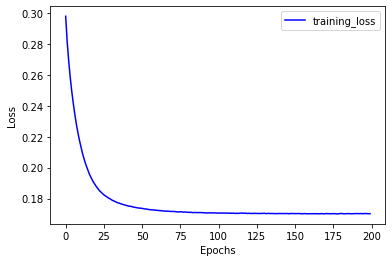

In [23]:
plt.plot(train_losses,c='b')
plt.legend(['training_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

### Inference Model

In [26]:
def user_items(df,user_id,key_userId,key_itemID):
#     if (str(type(user_id) == "<class 'list'>") or str(type(user_id) == "<class 'numpy.ndarray'>")):
#         def func(x):
#             return x.values
#         tdf = df[df[key_userId].isin(user_id)]
#         gb = tdf.groupby(key_userId)[key_itemID].apply(func).reset_index()
#         return gb[gb[key_userId].isin(user_id)]
    return df[df[key_userId]==user_id][key_itemID]

In [55]:
target_user = 651
readed_books = user_items(data, target_user,'user_id','book_id')

In [56]:
t = np.expand_dims(dense_rating[target_user],axis=0)
pred = model_session.run(out,feed_dict={x:t,drop_rate:0})[0]
k = 10
recommend_to_target = np.argsort(pred)[::-1][:k]

In [57]:
print("Books read by user:",target_user)
books[books['id'].isin(readed_books)].head(10)

Books read by user: 651


,id,book_id,authors,original_title,language_code,average_rating,ratings_count
5773,5773,3300,"Isabel Allende, Margaret Sayers Peden",Inés del alma mía,en-US,3.90,13539
6293,6293,11343348,"James Patterson, Mark T. Sullivan",Private Games,eng,3.83,14358
6466,6466,765811,Gloria Naylor,The Women of Brewster Place,en-US,4.13,14777
7514,7514,43081,"Rusty Young, Thomas McFadden","Marching Powder: A True Story of Friendship, C...",eng,4.22,7313
8448,8448,6751356,Dolen Perkins-Valdez,Wench,en-US,3.68,12250
9832,9832,10111087,Mark Adams,NaN,en-US,3.80,8650


In [58]:
print("Books recommended to user:", target_user)
books[books['id'].isin(recommend_to_target)]

Books recommended to user: 651


,id,book_id,authors,original_title,language_code,average_rating,ratings_count
250,250,233093,Dr. Seuss,The Cat in the Hat,eng,4.15,314016
264,264,14891,Betty Smith,A Tree Grows In Brooklyn,eng,4.24,291909
1417,1417,44688,David Eddings,Magician's Gambit,NaN,4.13,69616
2198,2198,89723,Shirley Jackson,The Lottery: Adventures of the Demon Lover,en-US,4.06,48608
2809,2809,16286,John Fowles,The Magus,en-US,4.04,32914
2987,2987,32979,"Carolyn Keene, Russell H. Tandy, Sara Paretsky",The Secret of the Old Clock (Nancy Drew Myster...,eng,3.98,44256
5471,5471,7187395,Richard Paul Evans,The Walk,en-US,4.12,16224
7871,7871,527862,Irvine Welsh,The Acid House,NaN,3.69,10752
8097,8097,1116393,Karen Miller,"Innocence Lost (Kingmaker, Kingbreaker, #2)",eng,3.71,12475
8146,8146,17835351,Sean Patrick,Nikola Tesla: Imagination and the Man That Inv...,eng,3.79,13584


In [59]:
np.intersect1d(readed_books,recommend_to_target)

array([], dtype=int64)

### Evaluate Model

In [60]:
items_interact = data.groupby('book_id')['user_id'].agg({'count':'count'}).reset_index()
users_interact = data.groupby('user_id')['book_id'].agg({'count':'count'}).reset_index()

f:\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
f:\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


#### Histogram distribution of number of rating/book
We can see most book have the same number of rating (~100)

Text(0, 0.5, 'Number of book')

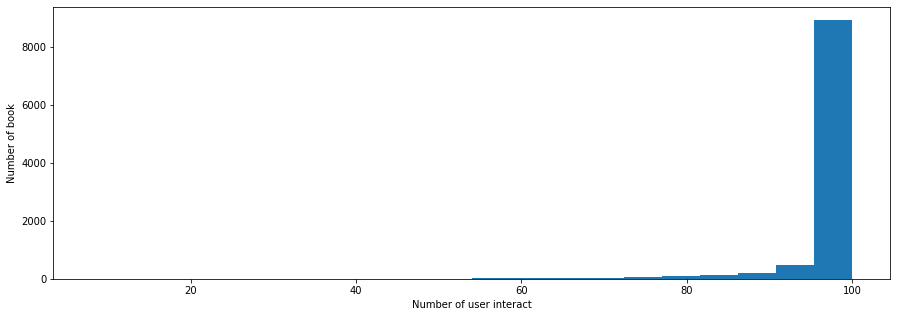

In [61]:
fig = plt.figure(figsize=[15,5])
_ = plt.hist(items_interact['count'],bins=20)
plt.xlabel('Number of user interact')
plt.ylabel('Number of book')

#### Histogram distribution of number of ratings given/user
We can see most people only read less than 15 books while very few read more than 50

Text(0, 0.5, 'Number of users')

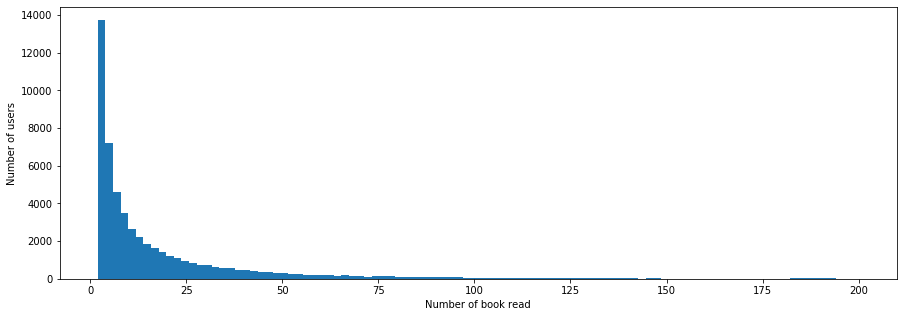

In [62]:
fig = plt.figure(figsize=[15,5])
_ = plt.hist(users_interact['count'],bins=100)
plt.xlabel('Number of book read')
plt.ylabel('Number of users')

#### Coverage of recommendation

In [63]:
k = 20
SAMPLE_SIZE = 10000
k_droprate = [0,0.2,0.5,0.8,0.99]
for dr in k_droprate:
    coverages = []
    for i in np.random.choice(num_user,SAMPLE_SIZE):
        t = np.expand_dims(dense_rating[i],axis=0)
        pred = model_session.run(out,feed_dict={x:t,drop_rate:dr})[0]
        recom = np.argsort(pred)[::-1][:k]
        coverages += recom.tolist()
    coverages = np.unique(coverages)
    coverages = len(coverages)/num_book
    print(f"At DropRate = {dr} - The model cover {coverages*100:.2f}% of items in the dataset")

At DropRate = 0 - The model cover 14.74% of items in the dataset
At DropRate = 0.2 - The model cover 18.86% of items in the dataset
At DropRate = 0.5 - The model cover 30.80% of items in the dataset
At DropRate = 0.8 - The model cover 56.25% of items in the dataset
At DropRate = 0.99 - The model cover 95.67% of items in the dataset


#### Personalization of the recommendation

In [64]:
from sklearn.metrics.pairwise import cosine_similarity

In [75]:
# Sample 5000 user to measure the similarity of their recommendation
# Calculate for 50k users is too much
SAMPLE_SIZE = 5000
k = 10
sample = np.random.choice(num_user,size=SAMPLE_SIZE,replace=False)
sample_user = dense_rating[sample]
sample_coverages = model_session.run(out,feed_dict={x:sample_user,drop_rate:0.2})
sample_recom = np.argsort(sample_coverages,axis=-1)[:,-k:]
 
recom_matrix = np.zeros([SAMPLE_SIZE,num_book])
for i in range(SAMPLE_SIZE):
    recom_matrix[i][sample_recom[i]]=1

similarity = cosine_similarity(recom_matrix)
# Personalized Score = 1 - mean_of_upper_triangle(similarity)
# The higher the score, the better
personalized_score = 1-np.sum(np.triu(similarity))/(np.prod(similarity.shape)/2)
print("Personalization Score =",personalized_score)

Personalization Score = 0.7073409279999998


#### Mean Average Precision & Mean Average Recall (MAP@K and MAR@K)
https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52

https://www.youtube.com/watch?v=pM6DJ0ZZee0

http://fastml.com/what-you-wanted-to-know-about-mean-average-precision/

![title](https://miro.medium.com/max/350/0*WcR6weG1ORhMcJOl.png)

In [ ]:
def average_precision(ground_truth,preds):
    precisions = []
    correct = 0
    for i,v in enumerate(preds):
        if v in ground_truth:
            correct+=1
            precisions.append(correct/(i+1))
    if correct == 0:
        return 0
    return np.sum(precisions)/correct

In [ ]:
# Sample 1000 user query
SAMPLE_SIZE = 1000
sample_idx = np.random.choice(num_user,size=SAMPLE_SIZE,replace=False)
sample = dense_rating[sample_idx]

In [ ]:
readed_books = user_items(data,sample_idx,'user_id','book_id')['book_id']

In [ ]:
k=20
pred = model_session.run(out,feed_dict={x:sample,
                                       drop_rate:0})
recom = np.argsort(pred,axis=-1)

In [ ]:
mapak = []
for truth,pred in zip(readed_books,recom):
    pred = pred[::-1][:k]
    mapak.append(average_precision(truth,pred))
print(np.mean(mapak))

In [ ]:
mapak = []
for truth,pred in zip(readed_books,recom):
    pred = np.random.choice(num_book,size=k)
    mapak.append(average_precision(truth,pred))
print(np.mean(mapak))